# Divergences for GVI BNN

In [1]:
import os
import sys
import math
import time
import random
import tempfile
sys.path.append('..')

import numpy as np
from scipy.special import softmax
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Custom
from utils.data import plot_toy_dataset, toy_dataset, plot_toy_regions
from utils.metrics import expected_calibration_error
from BNN_GVI_LR import BNN_GVILR

### General hyperparameters

In [2]:
dev = torch.device('cuda:0')

epochs = 3000
hidden_size = [30, 30]

pmean, plog_var = torch.Tensor([0]), torch.Tensor([0])

### Toy dataset

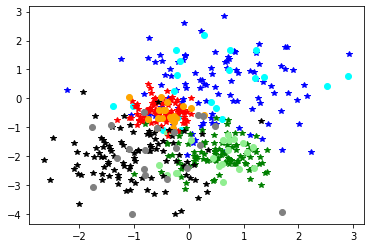

In [3]:
N = 400  # Samples to use

(X_tr, Y_tr), (X_te, Y_te) = toy_dataset(N=N)

N_tr = X_tr.shape[0]
N_te = X_te.shape[0]

plot_toy_dataset((X_tr, Y_tr), (X_te, Y_te))

In [4]:
X_tr = X_tr.to(dev)
Y_tr = Y_tr.to(dev)
X_te = X_te.to(dev)
Y_te = Y_te.to(dev)

### Train function

In [5]:
def train_bnn(bnn):
    
    optimizer = torch.optim.Adam(bnn.parameters(), lr=0.1)
    
    bnn_loss = []
    bnn_D = []
    bnn_NLL = []
    bnn_col = []
    bnn_train_error = []
    bnn_test_error = []
    
    # Train loop
    t0 = time.time()

    for e in range(epochs):

        cum_loss = 0
        cum_D = 0
        cum_NLL = 0
        cum_acc = 0
        cum_col = 0



        # Train
        bnn.train()
        _loss, _NLL, _D = bnn.ELBO(X_tr, Y_tr, warm_up=(e<10))

        preds = bnn(X_tr)
        _, _preds = torch.max(preds, dim=1)
        _acc = torch.sum(_preds==Y_tr)

        cum_loss += _loss.item()
        cum_NLL += _NLL.item()
        cum_D += _D.item()

        cum_acc += _acc.item()

        optimizer.zero_grad()
        _loss.backward()
        optimizer.step()

        cum_col += bnn._get_collapsed_posterior()


        # Test
        if e%50 == 0:
            bnn.eval()
            test_acc = 0
            preds = bnn.predictive(X_te, n_samples=100)

            _, _preds = torch.max(preds, dim=1)
            _acc = torch.sum(_preds==Y_te)
            test_acc += _acc.item()

        bnn_loss.append(cum_loss)
        bnn_D.append(cum_D)
        bnn_NLL.append(cum_NLL)
        bnn_col.append(cum_col.item())
        bnn_train_error.append(100.*(cum_acc)/N_tr)
        bnn_test_error.append(100.*(test_acc)/N_te)

        if e%5 == 4:
            print('epoch: {}, at time: {:.2f}, loss: {:.3e}, NLL: {:.3e}, D: {:.3e}, Train Acc: {:.2f}, Test Acc: {:.2f}, Collapsed params: {:.3f}%'.format(
                  e, time.time()-t0, bnn_loss[-1], bnn_NLL[-1], bnn_D[-1], bnn_train_error[-1], bnn_test_error[-1], bnn_col[-1]), end='\r')
            
    h = {
        'loss': bnn_loss,
        'D': bnn_D,
        'NLL': bnn_NLL,
        'col': bnn_col,
        'train_e': bnn_train_error,
        'test_e': bnn_test_error,

    }
            
    return h

In [6]:
def plot_training(h):
    fig, ax_arr = plt.subplots(2, 2, figsize=(16, 14))

    ax_arr[0, 0].plot(h['NLL'])
    ax_arr[0, 0].set_yscale('log')
    ax_arr[0, 0].set_title('NLL')


    ax_arr[0, 1].plot(h['D'])
    ax_arr[0, 1].set_yscale('log')
    ax_arr[0, 1].set_title('D')
    
    ax_arr[1, 0].plot(h['col'])
    ax_arr[1, 0].set_title('collapsed params')

    ax_arr[1, 1].plot(h['train_e'])
    ax_arr[1, 1].plot(h['test_e'])
    ax_arr[1, 1].set_title('Accuracy')
    ax_arr[1, 1].legend(['Train', 'Test'])

    plt.show()

## KL 

In [7]:
bnn_kl = BNN_GVILR(2, 4, pmean, plog_var, divergence='KL', hidden_size=hidden_size).to(dev)

In [8]:
h = train_bnn(bnn_kl)

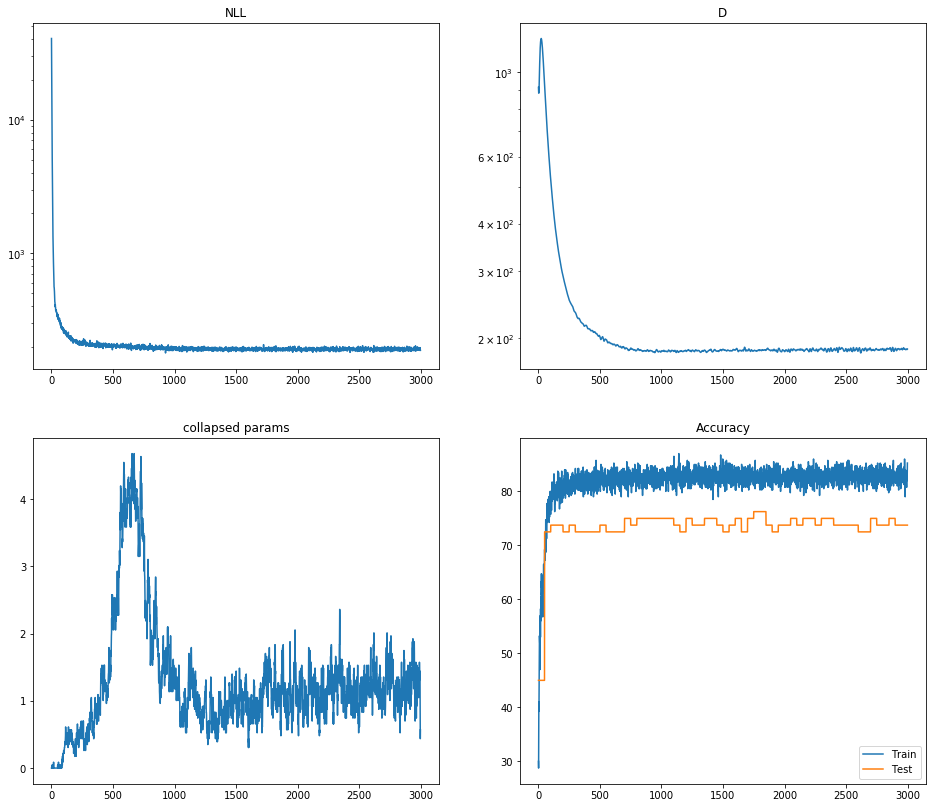

In [9]:
plot_training(h)

### Reverse KL

In [10]:
bnn_rkl = BNN_GVILR(2, 4, pmean, plog_var, divergence='rKL', hidden_size=hidden_size).to(dev)

In [11]:
rh = train_bnn(bnn_rkl)

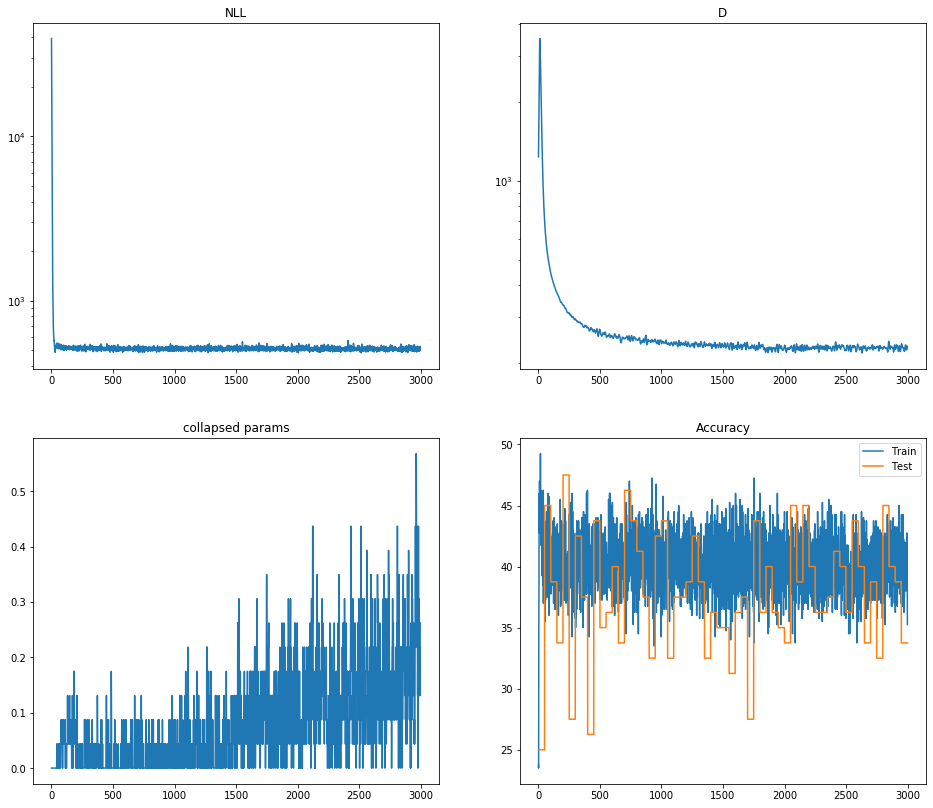

In [12]:
plot_training(rh)

### Fisher

In [13]:
bnn_f = BNN_GVILR(2, 4, pmean, plog_var, divergence='F', hidden_size=hidden_size).to(dev)

In [14]:
fh = train_bnn(bnn_f)

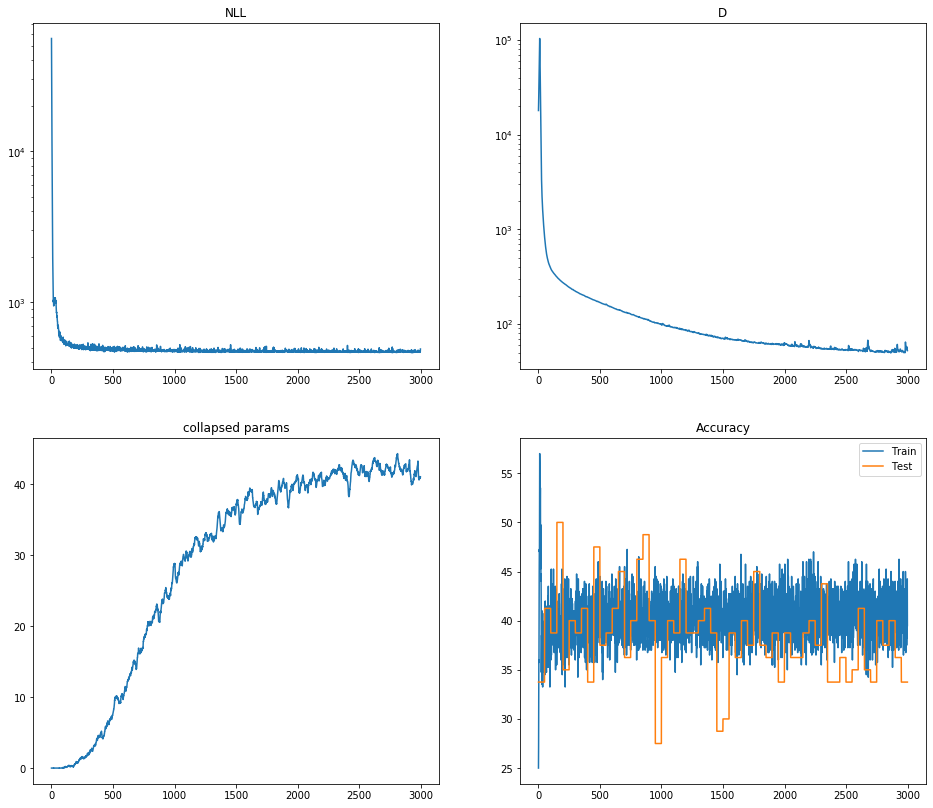

In [15]:
plot_training(fh)

### Jeffrey

In [16]:
bnn_j = BNN_GVILR(2, 4, pmean, plog_var, divergence='J', hidden_size=hidden_size).to(dev)

In [17]:
jh = train_bnn(bnn_j)

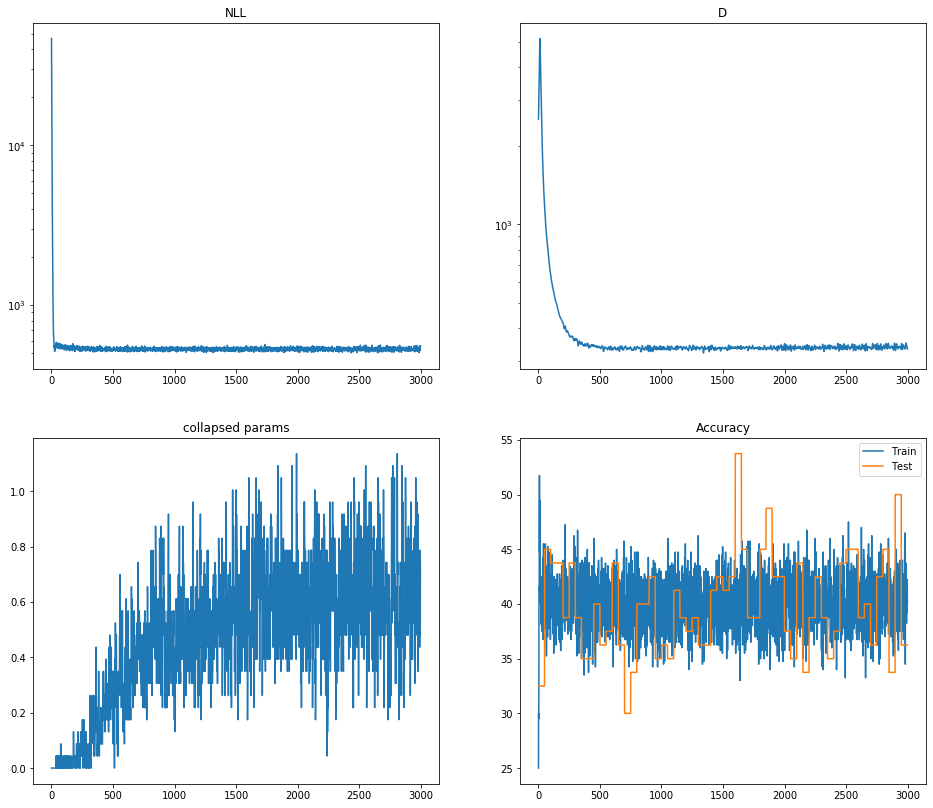

In [18]:
plot_training(jh)

### Alpha

In [19]:
bnn_a = BNN_GVILR(2, 4, pmean, plog_var, divergence='A', d_param=0.5, hidden_size=hidden_size).to(dev)

In [20]:
ah = train_bnn(bnn_a)

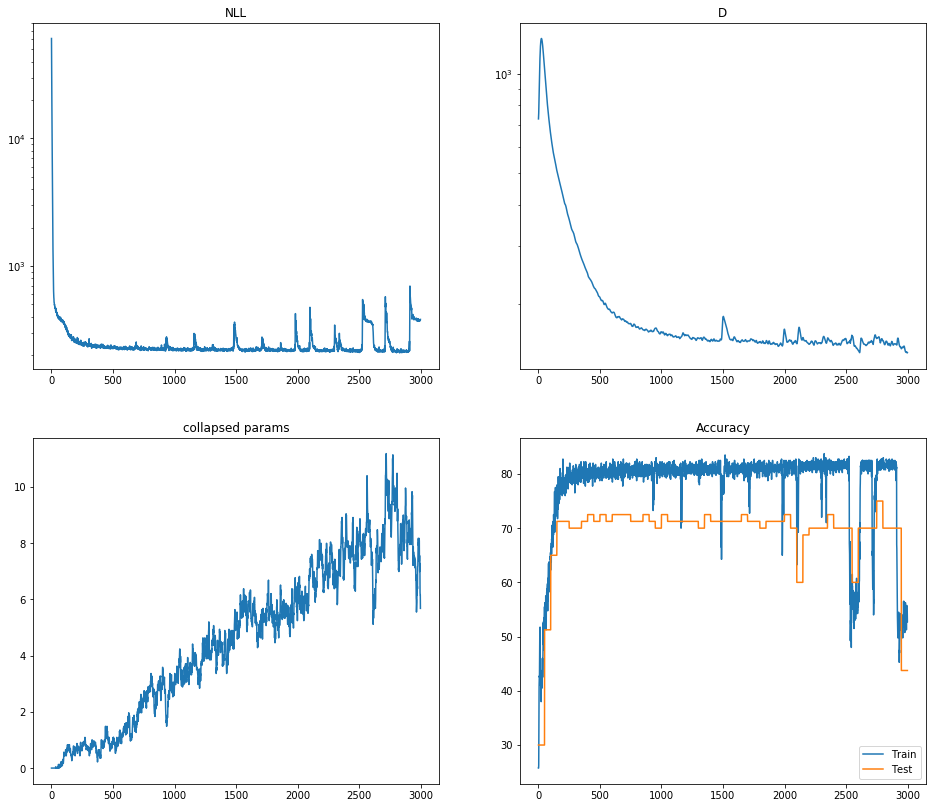

In [21]:
plot_training(ah)

### Renyi-Alpha

In [22]:
bnn_ar = BNN_GVILR(2, 4, pmean, plog_var, divergence='AR', d_param=0.5, hidden_size=hidden_size).to(dev)

In [23]:
arh = train_bnn(bnn_ar)

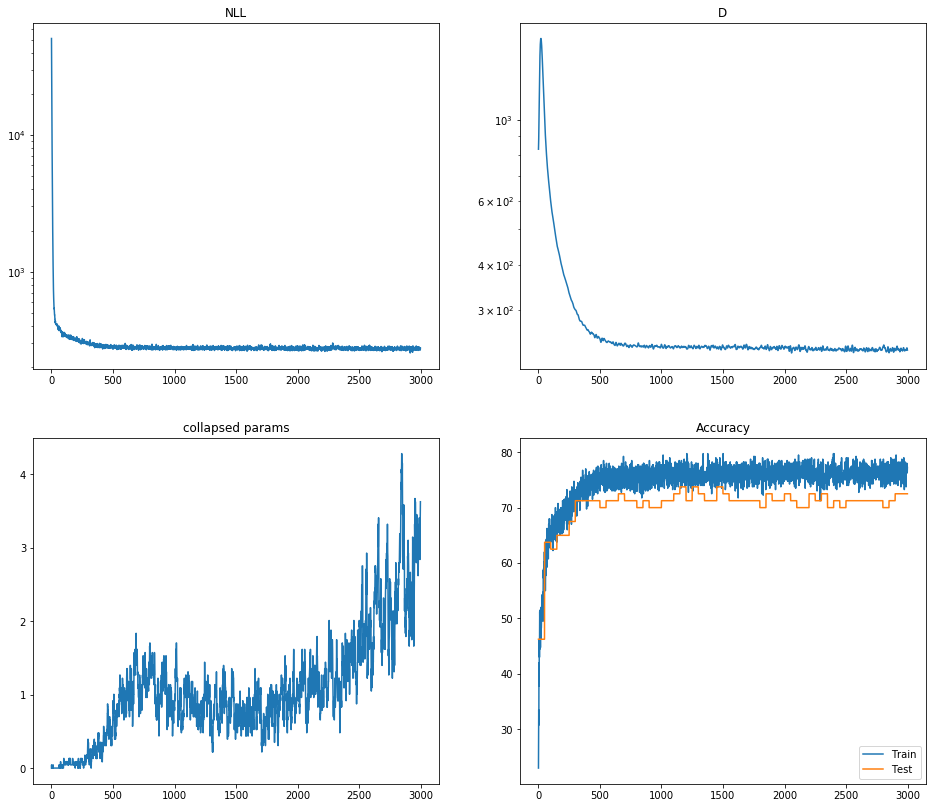

In [24]:
plot_training(arh)

### Beta

In [25]:
bnn_b = BNN_GVILR(2, 4, pmean, plog_var, divergence='B', d_param=1.25, hidden_size=hidden_size).to(dev)

In [26]:
bh = train_bnn(bnn_b)

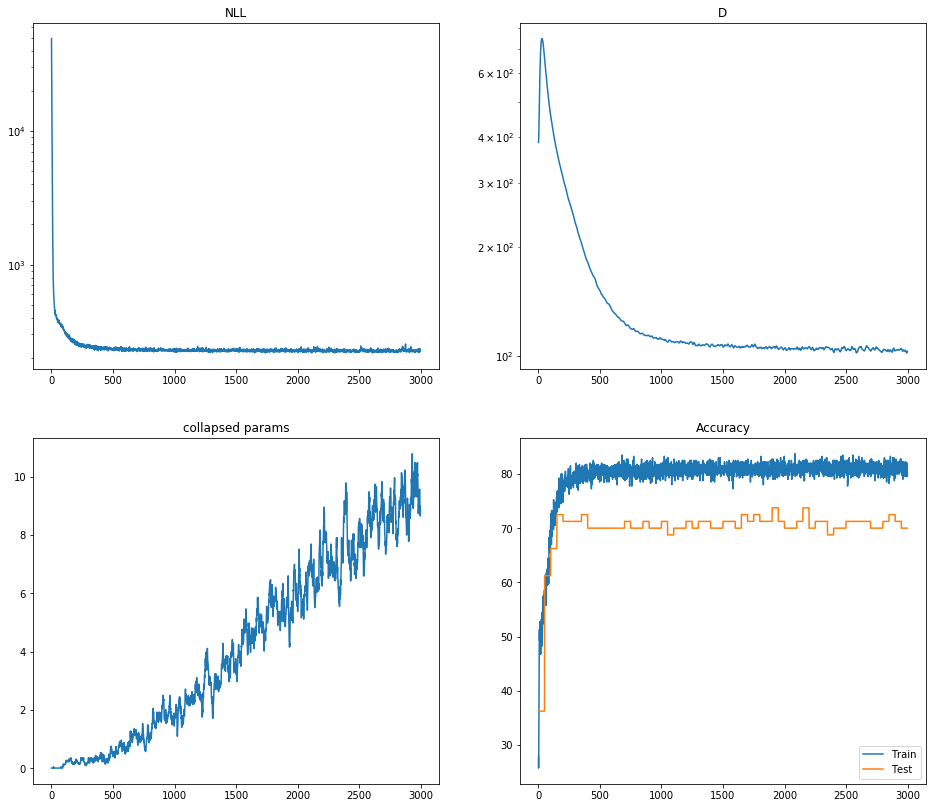

In [27]:
plot_training(bh)

### Gamma

In [28]:
bnn_g = BNN_GVILR(2, 4, pmean, plog_var, divergence='G', d_param=1.25, hidden_size=hidden_size).to(dev)

In [29]:
gh = train_bnn(bnn_g)

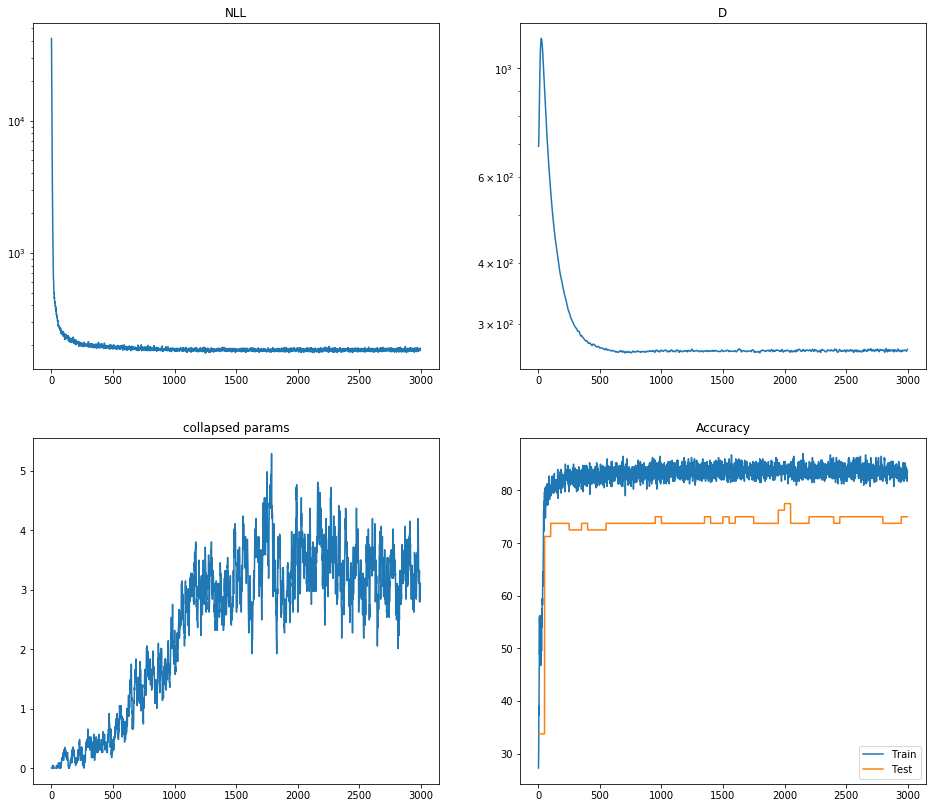

In [30]:
plot_training(gh)